In [7]:
#Gold Price Prediction: 

## Importing necessary libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from dotenv import load_dotenv
import mlflow

## End-to-End Machine Learning Workflow

Linear Regression - RMSE: 2.4928076611611645, MAE: 6.214090035543796, R²: 0.9987232350045929
Decision Tree - RMSE: 2.860023344281554, MAE: 8.179733529835444, R²: 0.9975042049613051
Random Forest - RMSE: 2.4960604837252873, MAE: 6.230317938414915, R²: 0.9986211276433999
Gradient Boosting - RMSE: 2.4451975787578237, MAE: 5.978991199163124, R²: 0.9987378518012521
XGBoost - RMSE: 2.579161031513822, MAE: 6.652071626479442, R²: 0.9983682171783683
SVR - RMSE: 14.018854711202389, MAE: 196.52828741380142, R²: -0.19880548759859296
Top 1 Model: Gradient Boosting with RMSE: 2.4451975787578237
Top 2 Model: Linear Regression with RMSE: 2.4928076611611645


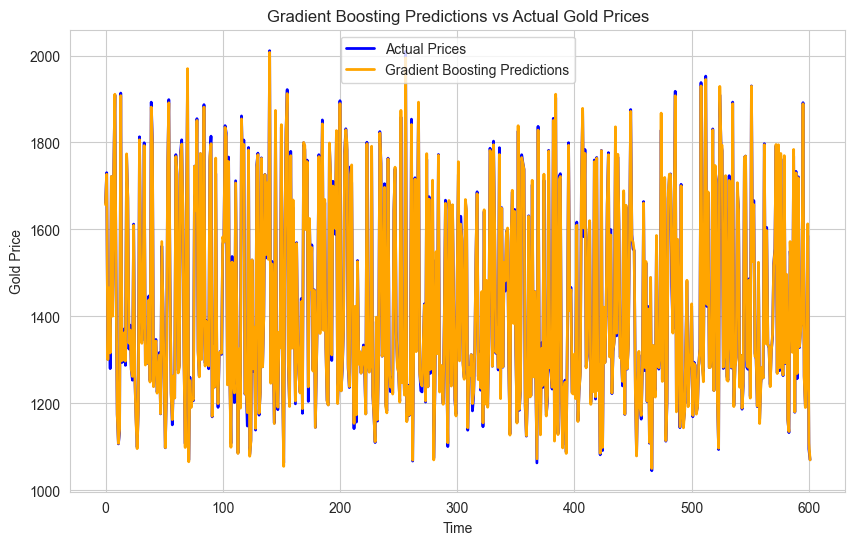

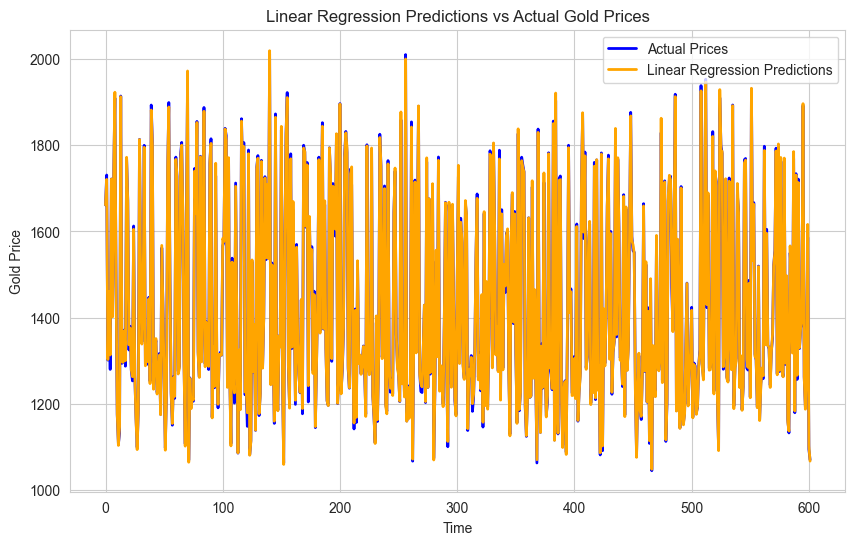

In [8]:

sns.set_style('whitegrid')

# -----------------------------------------------
# Load environment variables
# -----------------------------------------------
load_dotenv("../.env")
DagsHub_username = os.getenv("DagsHub_username")
DagsHub_token = os.getenv("DagsHub_token")
os.environ['MLFLOW_TRACKING_USERNAME'] = DagsHub_username
os.environ["MLFLOW_TRACKING_PASSWORD"] = DagsHub_token

mlflow.set_tracking_uri(f"https://dagshub.com/{DagsHub_username}/gold-price-prediction.mlflow")
mlflow.set_experiment("Gold Price Prediction")



# -----------------------------------------------
# Load the dataset
# -----------------------------------------------
df = pd.read_csv("../data/gold_data_clean.csv", skiprows=1)
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
df = df.dropna(subset=['Date'])
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df = df.dropna(subset=['Date'])

numeric_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna()

# Normalize the data
train_size = int(len(df['Close'].values) * 0.8)
train_data = df['Close'].values[:train_size]
test_data = df['Close'].values[train_size:]

# Prepare data for non-LSTM models
X = df[['Open', 'High', 'Low', 'Volume']].fillna(0).values
y = df['Close'].values
X_train, X_test, y_train, y_test = train_test_split(X[:train_size], y[:train_size], test_size=0.2, random_state=42)

# Dictionary to store models and their RMSEs
model_rmses = {}

# Define the models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(),
    "SVR": SVR()
}

# Train the models
for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Calculate RMSE, MAE, and R²
    rmse = np.sqrt(mean_absolute_error(y_test, predictions))
    mae = np.mean(np.abs(y_test - predictions))
    r2 = model.score(X_test, y_test)

    # Store model and its RMSE in a dictionary
    model_rmses[name] = (model, rmse)

    print(f"{name} - RMSE: {rmse}, MAE: {mae}, R²: {r2}")

# Select top 2 models with the lowest RMSE
best_models = sorted(model_rmses.items(), key=lambda x: x[1][1])[:2]

# Print the details of the best models
for i, (model_name, (model, rmse)) in enumerate(best_models, start=1):
    print(f"Top {i} Model: {model_name} with RMSE: {rmse}")


# Plotting the top models' predictions vs actual
for model_name, (model, rmse) in best_models:
    predictions = model.predict(X_test)
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label="Actual Prices", color='blue', linewidth=2)
    plt.plot(predictions, label=f"{model_name} Predictions", color='orange', linewidth=2)
    plt.title(f"{model_name} Predictions vs Actual Gold Prices")
    plt.xlabel("Time")
    plt.ylabel("Gold Price")
    plt.legend()
    plt.grid(True)
    plt.show()



## MLflow Logging for Top 1 Model: Gradient Boosting

In [134]:
# -----------------------------------------------
# MLflow Logging for Top 1 Model: Gradient Boosting
# -----------------------------------------------
with mlflow.start_run(run_name="Top 1 Model: Gradient Boosting"):
    # Log model-specific parameters
    mlflow.log_params(models["Gradient Boosting"].get_params())

    # Log additional metadata
    mlflow.set_tag("model_name", "Gradient Boosting")
    mlflow.set_tag("evaluation_metric", "RMSE")

    # Evaluate the model
    predictions = models["Gradient Boosting"].predict(X_test)
    rmse = np.sqrt(mean_absolute_error(y_test, predictions))
    mae = np.mean(np.abs(y_test - predictions))
    r2 = models["Gradient Boosting"].score(X_test, y_test)

    # Log metrics
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("R2", r2)

    # Log input data details
    mlflow.set_tag("train_features", 'Open, High, Low, Volume')
    mlflow.set_tag("train_label", 'Close')

    # Log the trained model
    mlflow.sklearn.log_model(models["Gradient Boosting"], artifact_path="models")
    
    print(f"Logged Gradient Boosting Model to MLflow with RMSE: {rmse}")


2024/12/18 00:57:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged Gradient Boosting Model to MLflow with RMSE: 2.4527742198917726
🏃 View run Top 1 Model: Gradient Boosting at: https://dagshub.com/hentatiamin0/gold-price-prediction.mlflow/#/experiments/1/runs/f8419d5fa9db40bb9e68047a508baa29
🧪 View experiment at: https://dagshub.com/hentatiamin0/gold-price-prediction.mlflow/#/experiments/1


## MLflow Logging for Top 2 Model: Random Forest

In [135]:
# -----------------------------------------------
# MLflow Logging for Top 2 Model: Random Forest
# -----------------------------------------------
with mlflow.start_run(run_name="Top 2 Model: Random Forest"):
    # Log model-specific parameters
    mlflow.log_params(models["Random Forest"].get_params())

    # Log additional metadata
    mlflow.set_tag("model_name", "Random Forest")
    mlflow.set_tag("evaluation_metric", "RMSE")

    # Evaluate the model
    predictions = models["Random Forest"].predict(X_test)
    rmse = np.sqrt(mean_absolute_error(y_test, predictions))
    mae = np.mean(np.abs(y_test - predictions))
    r2 = models["Random Forest"].score(X_test, y_test)

    # Log metrics
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("R2", r2)

    # Log input data details
    mlflow.set_tag("train_features", 'Open, High, Low, Volume')
    mlflow.set_tag("train_label", 'Close')

    # Log the trained model
    mlflow.sklearn.log_model(models["Random Forest"], artifact_path="models")
    
    print(f"Logged Random Forest Model to MLflow with RMSE: {rmse}")


2024/12/18 00:58:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged Random Forest Model to MLflow with RMSE: 2.49101316532406
🏃 View run Top 2 Model: Random Forest at: https://dagshub.com/hentatiamin0/gold-price-prediction.mlflow/#/experiments/1/runs/4e9efd03f5a64f338ba623716bc4813d
🧪 View experiment at: https://dagshub.com/hentatiamin0/gold-price-prediction.mlflow/#/experiments/1


## Retrieve the Run ID with the Highest RMSE Below 10 Across All MLflow Experiments

In [139]:
all_experiments = [exp.experiment_id for exp in mlflow.search_experiments()]
df_mlflow = mlflow.search_runs(experiment_ids=all_experiments, filter_string="metrics.RMSE<10")

# Correct column reference
run_id = df_mlflow.loc[df_mlflow['metrics.RMSE'].idxmax()]['run_id']

print(f"The run ID with the highest RMSE under 10 is: {run_id}")


The run ID with the highest RMSE under 10 is: 4e9efd03f5a64f338ba623716bc4813d


In [140]:
df_mlflow

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.R2,metrics.MAE,metrics.RMSE,params.min_weight_fraction_leaf,...,params.n_iter_no_change,tags.train_label,tags.mlflow.user,tags.evaluation_metric,tags.mlflow.log-model.history,tags.mlflow.source.type,tags.mlflow.source.name,tags.model_name,tags.mlflow.runName,tags.train_features
0,4e9efd03f5a64f338ba623716bc4813d,1,FINISHED,mlflow-artifacts:/99d6815f2b6f4039a049a73b9ea1...,2024-12-17 23:58:09.291000+00:00,2024-12-17 23:59:00.765000+00:00,0.998624,6.205147,2.491013,0.0,...,None,Close,hentatiamin0,RMSE,"[{""run_id"": ""4e9efd03f5a64f338ba623716bc4813d""...",LOCAL,C:\Users\henta\AppData\Local\Programs\Python\P...,Random Forest,Top 2 Model: Random Forest,"Open, High, Low, Volume"
1,f8419d5fa9db40bb9e68047a508baa29,1,FINISHED,mlflow-artifacts:/99d6815f2b6f4039a049a73b9ea1...,2024-12-17 23:57:08.152000+00:00,2024-12-17 23:57:18.159000+00:00,0.998701,6.016101,2.452774,0.0,...,None,Close,hentatiamin0,RMSE,"[{""run_id"": ""f8419d5fa9db40bb9e68047a508baa29""...",LOCAL,C:\Users\henta\AppData\Local\Programs\Python\P...,Gradient Boosting,Top 1 Model: Gradient Boosting,"Open, High, Low, Volume"


## Display the Columns of the Filtered MLflow Runs DataFrame

In [141]:
print(df_mlflow.columns)


Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.R2', 'metrics.MAE', 'metrics.RMSE',
       'params.min_weight_fraction_leaf', 'params.max_features',
       'params.monotonic_cst', 'params.max_leaf_nodes', 'params.verbose',
       'params.random_state', 'params.oob_score', 'params.criterion',
       'params.n_estimators', 'params.max_depth', 'params.min_samples_leaf',
       'params.n_jobs', 'params.min_samples_split',
       'params.min_impurity_decrease', 'params.warm_start', 'params.ccp_alpha',
       'params.bootstrap', 'params.max_samples', 'params.init', 'params.loss',
       'params.subsample', 'params.alpha', 'params.tol',
       'params.learning_rate', 'params.validation_fraction',
       'params.n_iter_no_change', 'tags.train_label', 'tags.mlflow.user',
       'tags.evaluation_metric', 'tags.mlflow.log-model.history',
       'tags.mlflow.source.type', 'tags.mlflow.source.name', 'tags.model_name',
       'tags.mlflow.runName

## Hyperparameter Tuning for GradientBoostingRegressor with GridSearchCV and MLflow Logging

In [9]:
# Section 1: GradientBoostingRegressor
# ---------------------------------------------------------

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to test
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

# Grid search for GradientBoosting
model = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    verbose=1
)

# Fit the model with GridSearch
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions and evaluate
predictions = best_model.predict(X_test)
rmse = np.sqrt(mean_absolute_error(y_test, predictions))

print(f"Gradient Boosting RMSE: {rmse}")
print(f"Best Hyperparameters: {best_params}")

# Log everything to MLflow
with mlflow.start_run(run_name="GradientBoosting_tuned"):
    mlflow.log_params(best_params)
    mlflow.log_metrics({"RMSE": rmse})
    mlflow.sklearn.log_model(best_model, "GradientBoosting_tuned")


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Gradient Boosting RMSE: 2.430420342596634
Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


2024/12/18 09:42:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run GradientBoosting_tuned at: https://dagshub.com/hentatiamin0/gold-price-prediction.mlflow/#/experiments/1/runs/fdddb59bd8b34b5a980987a55b3efe39
🧪 View experiment at: https://dagshub.com/hentatiamin0/gold-price-prediction.mlflow/#/experiments/1


Fitting 5 folds for each of 4 candidates, totalling 20 fits


2024/12/18 09:58:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best Hyperparameters: {'copy_X': True, 'fit_intercept': True}
RMSE: 2.4928076611611645
R² Score: 0.9987232350045929


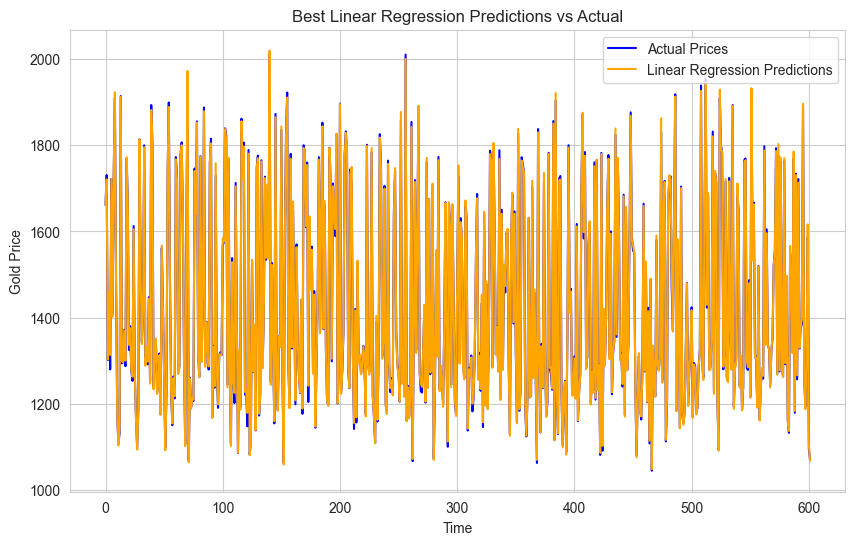

🏃 View run Linear Regression GridSearch at: https://dagshub.com/hentatiamin0/gold-price-prediction.mlflow/#/experiments/1/runs/e6b469b5385642c6b37eac5e656b2d2c
🧪 View experiment at: https://dagshub.com/hentatiamin0/gold-price-prediction.mlflow/#/experiments/1


In [22]:
# Define hyperparameters to search over for Linear Regression
param_grid_lr = {
    'fit_intercept': [True, False],
    'copy_X': [True, False]
}

# Set up GridSearchCV
grid_search_lr = GridSearchCV(
    estimator=LinearRegression(),
    param_grid=param_grid_lr,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='neg_mean_absolute_error'
)

# Start MLflow run for Grid Search
with mlflow.start_run(run_name="Linear Regression GridSearch"):
    # Fit GridSearchCV on the training data
    grid_search_lr.fit(X_train, y_train)

    # Get the best model and hyperparameters
    best_lr_model = grid_search_lr.best_estimator_
    best_params = grid_search_lr.best_params_
    best_predictions = best_lr_model.predict(X_test)
    best_rmse = np.sqrt(mean_absolute_error(y_test, best_predictions))
    best_r2 = best_lr_model.score(X_test, y_test)

    # Log the best hyperparameters and evaluation metrics
    mlflow.log_params(best_params)
    mlflow.log_metrics({"RMSE": best_rmse, "R²": best_r2})
    mlflow.sklearn.log_model(best_lr_model, "linear_regression_best")

    print(f"Best Hyperparameters: {best_params}")
    print(f"RMSE: {best_rmse}")
    print(f"R² Score: {best_r2}")

    # Plotting actual vs predictions
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label="Actual Prices", color='blue')
    plt.plot(best_predictions, label=f"Linear Regression Predictions", color='orange')
    plt.title(f"Best Linear Regression Predictions vs Actual")
    plt.xlabel("Time")
    plt.ylabel("Gold Price")
    plt.legend()
    plt.grid(True)
    plt.show()


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)  # Regression output layer
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=200, batch_size=32, verbose=1)

# Evaluate
nn_predictions = model.predict(X_test_scaled)
nn_rmse = np.sqrt(mean_squared_error(y_test, nn_predictions))

print(f"Neural Network RMSE: {nn_rmse}")


Epoch 1/200


C:\Users\henta\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2021112.8750 - mae: 1402.7944 - val_loss: 2034606.6250 - val_mae: 1406.8640
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1957405.3750 - mae: 1380.7751 - val_loss: 1796876.6250 - val_mae: 1321.6644
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1659259.7500 - mae: 1268.5917 - val_loss: 1195970.7500 - val_mae: 1071.5607
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 998386.9375 - mae: 967.4310 - val_loss: 483166.1250 - val_mae: 643.2299
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 390102.4688 - mae: 559.9998 - val_loss: 200740.7656 - val_mae: 377.4281
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 201662.9062 - mae: 376.9982 - val_loss: 166627.8594 - val_mae: 344.6038
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 176108.2031 - mae: 352.3522 - val_loss: 147032.6250 - val_mae: 326.2667
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 153951.4688 - mae: 328.9

C:\Users\henta\AppData\Local\Temp\ipykernel_12392\1732821061.py:88: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


Linear Regression - RMSE: 0.029987736619188948, MAE: 0.0008992643475418459, R²: 0.9999037568198753
Decision Tree - RMSE: 0.061106748518030066, MAE: 0.0037340347144457697, R²: 0.9982311134558151
Random Forest - RMSE: 0.053692614168704085, MAE: 0.0028828968162693228, R²: 0.9990784050705888
Gradient Boosting - RMSE: 0.053429762275076224, MAE: 0.0028547394967711587, R²: 0.9991359898430349
XGBoost - RMSE: 0.053239558552693626, MAE: 0.0028344505948856933, R²: 0.999113857829318
SVR - RMSE: 0.24144544638146367, MAE: 0.05829590357834425, R²: 0.7654131927591235
Top 1 Model: Linear Regression with RMSE: 0.029987736619188948
Top 2 Model: XGBoost with RMSE: 0.053239558552693626


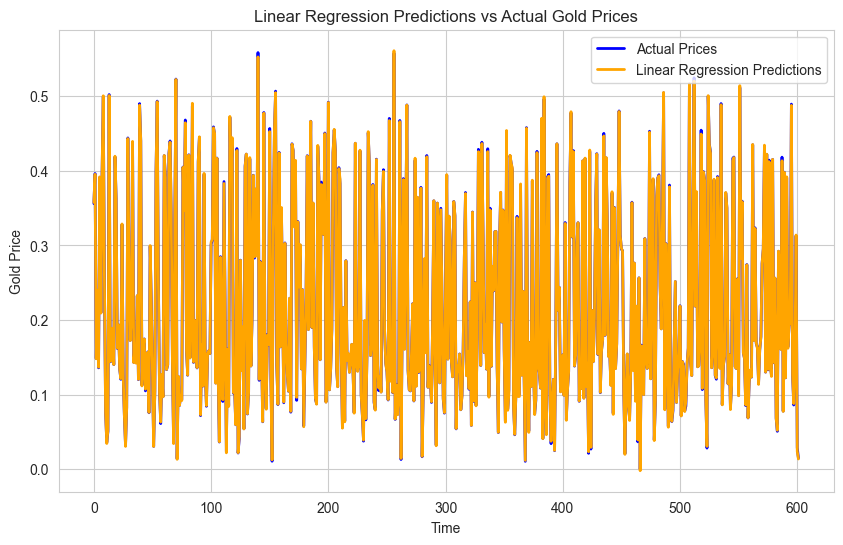

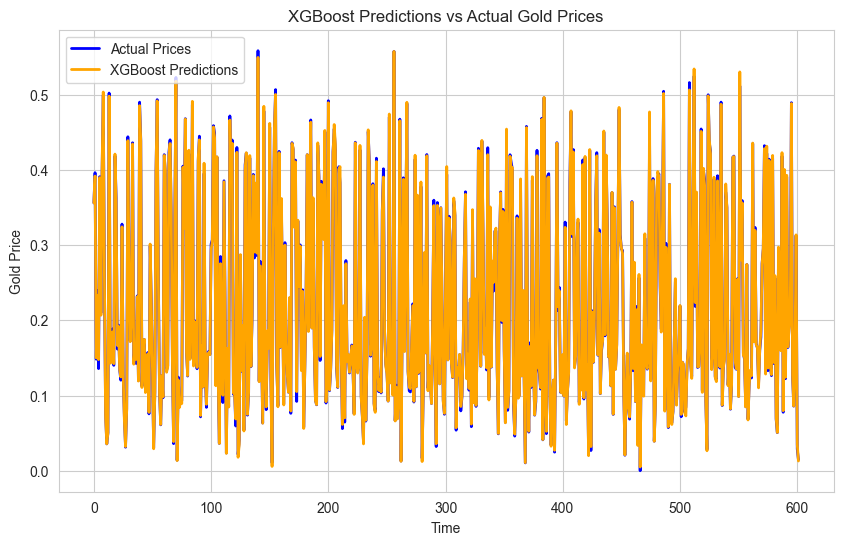

2024/12/18 10:19:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged Linear Regression Model to MLflow with RMSE: 0.029987736619188948
🏃 View run Top 1 Model: Linear Regression at: https://dagshub.com/hentatiamin0/gold-price-prediction.mlflow/#/experiments/1/runs/34ff76ceb0f9467dbae6992b60aa39c8
🧪 View experiment at: https://dagshub.com/hentatiamin0/gold-price-prediction.mlflow/#/experiments/1


2024/12/18 10:20:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged XGBoost Model to MLflow with RMSE: 0.053239558552693626
🏃 View run Top 2 Model: XGBoost at: https://dagshub.com/hentatiamin0/gold-price-prediction.mlflow/#/experiments/1/runs/3677e9a939af4bb1a7e55a01d2f4ea0c
🧪 View experiment at: https://dagshub.com/hentatiamin0/gold-price-prediction.mlflow/#/experiments/1


In [36]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from dotenv import load_dotenv
import mlflow

sns.set_style('whitegrid')

# -----------------------------------------------
# Load environment variables
# -----------------------------------------------
load_dotenv("../.env")
DagsHub_username = os.getenv("DagsHub_username")
DagsHub_token = os.getenv("DagsHub_token")
os.environ['MLFLOW_TRACKING_USERNAME'] = DagsHub_username
os.environ["MLFLOW_TRACKING_PASSWORD"] = DagsHub_token

mlflow.set_tracking_uri(f"https://dagshub.com/{DagsHub_username}/gold-price-prediction.mlflow")
mlflow.set_experiment("Gold Price Prediction")

# -----------------------------------------------
# Load the dataset
# -----------------------------------------------
df = pd.read_csv("../data/gold_data_clean.csv", skiprows=1)
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
df = df.dropna(subset=['Date'])
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df = df.dropna(subset=['Date'])

numeric_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna()

# -----------------------------------------------
# Feature Engineering
# -----------------------------------------------
# Date Features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['WeekOfYear'] = df['Date'].dt.isocalendar().week

# Rolling window features
df['RollingMean_7'] = df['Close'].rolling(window=7).mean()
df['RollingStd_7'] = df['Close'].rolling(window=7).std()
df['RollingMean_30'] = df['Close'].rolling(window=30).mean()
df['RollingStd_30'] = df['Close'].rolling(window=30).std()

# Lag features
df['Lag_1'] = df['Close'].shift(1)
df['Lag_7'] = df['Close'].shift(7)
df['Lag_30'] = df['Close'].shift(30)

# Price Change Features
df['PriceChange'] = df['Close'].pct_change()
df['PriceChange_7'] = df['Close'].pct_change(periods=7)
df['PriceChange_30'] = df['Close'].pct_change(periods=30)

# Technical Indicators
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

df['BollingerUpper'] = df['RollingMean_30'] + 2 * df['RollingStd_30']
df['BollingerLower'] = df['RollingMean_30'] - 2 * df['RollingStd_30']

# Fill NaN values generated by rolling and shift operations
df.fillna(method='bfill', inplace=True)

# Interaction Features
df['Open_High_Interaction'] = df['Open'] * df['High']
df['Low_Volume_Interaction'] = df['Low'] * df['Volume']
df['Close_Volume_Interaction'] = df['Close'] * df['Volume']

# Normalize the features
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])

# -----------------------------------------------
# Prepare the data for training
# -----------------------------------------------
train_size = int(len(df['Close'].values) * 0.8)
train_data = df['Close'].values[:train_size]
test_data = df['Close'].values[train_size:]

X = df[['Open', 'High', 'Low', 'Volume', 'Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear', 'Lag_1', 'Lag_7', 'Lag_30', 'RSI', 'MACD', 'MACD_Signal', 'BollingerUpper', 'BollingerLower', 'PriceChange', 'PriceChange_7', 'PriceChange_30', 'Open_High_Interaction', 'Low_Volume_Interaction', 'Close_Volume_Interaction']].fillna(0).values
y = df['Close'].values
X_train, X_test, y_train, y_test = train_test_split(X[:train_size], y[:train_size], test_size=0.2, random_state=42)

# -----------------------------------------------
# Define and Train the Models
# -----------------------------------------------
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(),
    "SVR": SVR()
}

model_rmses = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    rmse = np.sqrt(mean_absolute_error(y_test, predictions))
    mae = np.mean(np.abs(y_test - predictions))
    r2 = model.score(X_test, y_test)

    model_rmses[name] = (model, rmse)

    print(f"{name} - RMSE: {rmse}, MAE: {mae}, R²: {r2}")

# -----------------------------------------------
# Select Top Models
# -----------------------------------------------
best_models = sorted(model_rmses.items(), key=lambda x: x[1][1])[:2]

for i, (model_name, (model, rmse)) in enumerate(best_models, start=1):
    print(f"Top {i} Model: {model_name} with RMSE: {rmse}")

# Plotting the predictions vs actual for the best models
for model_name, (model, rmse) in best_models:
    predictions = model.predict(X_test)
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label="Actual Prices", color='blue', linewidth=2)
    plt.plot(predictions, label=f"{model_name} Predictions", color='orange', linewidth=2)
    plt.title(f"{model_name} Predictions vs Actual Gold Prices")
    plt.xlabel("Time")
    plt.ylabel("Gold Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# -----------------------------------------------
# MLflow Logging for Top Models
# -----------------------------------------------
top_models = [best_models[0], best_models[1]]
for i, (model_name, (model, rmse)) in enumerate(top_models, start=1):
    with mlflow.start_run(run_name=f"Top {i} Model: {model_name}"):
        mlflow.log_params(model.get_params())
        mlflow.set_tag("model_name", model_name)
        mlflow.set_tag("evaluation_metric", "RMSE")
        
        predictions = model.predict(X_test)
        rmse = np.sqrt(mean_absolute_error(y_test, predictions))
        mae = np.mean(np.abs(y_test - predictions))
        r2 = model.score(X_test, y_test)

        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("R2", r2)
        mlflow.set_tag("train_features", 'Open, High, Low, Volume, Year, Month, Day, DayOfWeek, WeekOfYear, Lag_1, Lag_7, Lag_30, RSI, MACD, MACD_Signal, BollingerUpper, BollingerLower, PriceChange, PriceChange_7, PriceChange_30, Open_High_Interaction, Low_Volume_Interaction, Close_Volume_Interaction')
        mlflow.set_tag("train_label", 'Close')

        mlflow.sklearn.log_model(model, artifact_path="models")

        print(f"Logged {model_name} Model to MLflow with RMSE: {rmse}")
